- ~~Date to datetime & to ordinal~~
- ~~Clean school_holiday to 1,2,3,4 instead of 0,a,b,c. Is this important?~~
- ~~Remove sundays and open 0~~
- Deliverables: Validation -> index and sales / ~~Pickle version~~ - Requirements.txt file - Separated feature engineering 
- Test in another computer 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
#pip install xgboost
import xgboost
from sklearn.metrics import r2_score

In [2]:
sales = pd.read_csv('sales.csv')
sales.rename(columns={'Unnamed: 0':'index'},inplace=True)
sales.set_index('index',inplace=True)
display(sales.head())
sales.shape

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
index,,,,,,,,,
425390,366,4,2013-04-18,517,1,0,0,0,4422
291687,394,6,2015-04-11,694,1,0,0,0,8297
411278,807,4,2013-08-29,970,1,1,0,0,9729
664714,802,2,2013-05-28,473,1,1,0,0,6513
540835,726,4,2013-10-10,1068,1,1,0,0,10882


(640840, 9)

In [3]:
sales.dtypes
# Convert date
# Re-mapping state_holiday with get_dummies

store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   store_ID             640840 non-null  int64 
 1   day_of_week          640840 non-null  int64 
 2   date                 640840 non-null  object
 3   nb_customers_on_day  640840 non-null  int64 
 4   open                 640840 non-null  int64 
 5   promotion            640840 non-null  int64 
 6   state_holiday        640840 non-null  object
 7   school_holiday       640840 non-null  int64 
 8   sales                640840 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 48.9+ MB


In [5]:
import datetime 
sales[["Year","Month","Day"]] = sales["date"].str.split("-", expand = True)
sales["date"]=pd.to_datetime(sales["date"])

In [6]:
sales.drop('date',axis=1,inplace=True)

In [7]:
# mean customers per Days of the week 
sales.groupby('day_of_week').agg({'nb_customers_on_day':'mean'})

,nb_customers_on_day
day_of_week,
1,812.724473
2,761.313712
3,721.166916
4,698.434165
5,742.724348
6,657.270157
7,36.959956


In [8]:
# state_holiday : Encoded 0, a, b, c indicating if there was a state holiday at all (0 if not), 
#and otherwise, the number indicates which state holiday it was.
sales['state_holiday'].value_counts()

0    621160
a     12842
b      4214
c      2624
Name: state_holiday, dtype: int64

In [9]:
# Checking if state_holiday a-b-c should be removed
#sales[sales['open']==0][['open','school_holiday','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]

In [10]:
sales_dummies = pd.get_dummies(sales, columns = ['state_holiday'])
sales_dummies.drop(['open','state_holiday_a','state_holiday_b','state_holiday_c'],axis=1,inplace=True)
sales_dummies = sales_dummies[sales_dummies['sales']!=0]
sales_dummies.head()

# Without sales
#sales_dummies[sales_dummies['sales']==0]

# Without sales and open
#sales_dummies[(sales_dummies['sales']==0)&(sales_dummies['open']==1)].shape

#display(sales_dummies['state_holiday_0'].value_counts())
#display(sales_dummies['state_holiday_a'].value_counts())
#display(sales_dummies['state_holiday_b'].value_counts())
#display(sales_dummies['state_holiday_c'].value_counts())

,store_ID,day_of_week,nb_customers_on_day,promotion,school_holiday,sales,Year,Month,Day,state_holiday_0
index,,,,,,,,,,
425390,366,4,517,0,0,4422,2013,04,18,1
291687,394,6,694,0,0,8297,2015,04,11,1
411278,807,4,970,1,0,9729,2013,08,29,1
664714,802,2,473,1,0,6513,2013,05,28,1
540835,726,4,1068,1,0,10882,2013,10,10,1


In [11]:
sales_dummies['Year'] = sales_dummies['Year'].astype(int)
sales_dummies['Month'] = sales_dummies['Month'].astype(int)
sales_dummies['Day'] = sales_dummies['Day'].astype(int)
sales_dummies.dtypes

store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
promotion              int64
school_holiday         int64
sales                  int64
Year                   int64
Month                  int64
Day                    int64
state_holiday_0        uint8
dtype: object

In [12]:
sales_corr = sales_dummies[['day_of_week','nb_customers_on_day','promotion','sales','school_holiday','state_holiday_0']].corr()
sales_corr


,day_of_week,nb_customers_on_day,promotion,sales,school_holiday,state_holiday_0
day_of_week,1.000000,-0.096492,-0.289307,-0.178065,-0.140424,0.002351
nb_customers_on_day,-0.096492,1.000000,0.182394,0.823659,0.025003,-0.050966
promotion,-0.289307,0.182394,1.000000,0.367512,0.028352,-0.002576
sales,-0.178065,0.823659,0.367512,1.000000,0.038637,-0.020768
school_holiday,-0.140424,0.025003,0.028352,0.038637,1.000000,-0.013590
state_holiday_0,0.002351,-0.050966,-0.002576,-0.020768,-0.013590,1.000000


<AxesSubplot:>

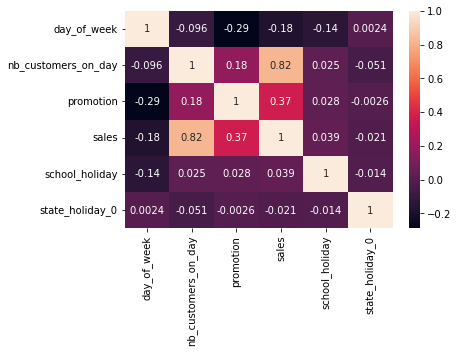

In [13]:
sns.heatmap(sales_corr,annot=True, xticklabels = sales_corr.columns,yticklabels = sales_corr.columns)

Filtered only open days
sales_open = sales_dummies[sales_dummies['open']==1]
sales_open_corr = sales_open[['day_of_week','nb_customers_on_day','promotion','sales','school_holiday','state_holiday_0']].corr()
sns.heatmap(sales_open_corr,annot=True, xticklabels = sales_open_corr.columns,yticklabels = sales_open_corr.columns)

<AxesSubplot:>

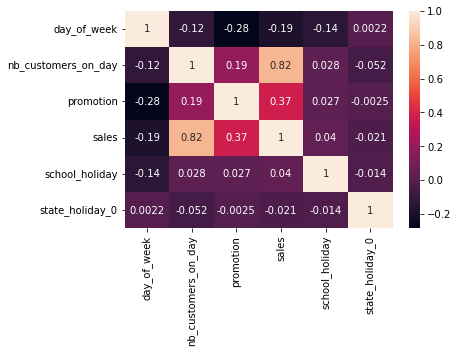

In [14]:
# Filtered only Mon-Sat
sales_without_sunday = sales_dummies[sales_dummies['day_of_week']!=7]
sales_without_sunday_corr = sales_without_sunday[['day_of_week','nb_customers_on_day','promotion','sales','school_holiday','state_holiday_0']].corr()
sns.heatmap(sales_without_sunday_corr,annot=True, xticklabels = sales_without_sunday_corr.columns,yticklabels = sales_without_sunday_corr.columns)

Filtered only open days & only Mon-Sat
sales_open_without_sunday = sales_dummies[(sales_dummies['day_of_week']!=7) & (sales_dummies['open']==1)]
sales_open_without_sunday_corr = sales_open_without_sunday[['day_of_week','nb_customers_on_day','promotion','sales','school_holiday','state_holiday_0']].corr()
sns.heatmap(sales_open_without_sunday_corr,annot=True, xticklabels = sales_open_without_sunday_corr.columns,yticklabels = sales_open_without_sunday_corr.columns)

In [15]:
print('without sunday')
display(sales_without_sunday.groupby('day_of_week').agg({'nb_customers_on_day':'count'}))
#print('only open')
#display(sales_open.groupby('day_of_week').agg({'nb_customers_on_day':'count'}))

without sunday


,nb_customers_on_day
day_of_week,
1,86454
2,90595
3,89272
4,84879
5,87574
6,90898


In [16]:
#print('without sunday and open')
#display(sales_dummies[(sales_dummies['day_of_week']!=7) & (sales_dummies['open']==1)]['sales'].mean())
#print('only open')
#display(sales_dummies[sales_dummies['open']==1]['sales'].mean())
#print('only sundays')
#display(sales_dummies[sales_dummies['day_of_week']==7]['sales'].mean())

In [17]:
sales_dummies.drop(['Year','Month','Day'],axis=1,inplace=True)

In [18]:
sales_train = sales_dummies[['day_of_week','nb_customers_on_day','promotion','school_holiday','sales','state_holiday_0']]
sales_train.head()

,day_of_week,nb_customers_on_day,promotion,school_holiday,sales,state_holiday_0
index,,,,,,
425390,4,517,0,0,4422,1
291687,6,694,0,0,8297,1
411278,4,970,1,0,9729,1
664714,2,473,1,0,6513,1
540835,4,1068,1,0,10882,1


In [19]:
X = sales_train.drop(['sales'], axis = 1)
y = sales_train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

gb_reg = GradientBoostingRegressor(max_depth=5, #gradient boosting always works with trees, no need to call the tree regressor
                                   n_estimators=100,
                                   random_state=1 # tastes like chicken
                                   )
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test,y_test)

from sklearn.model_selection import cross_validate
results = cross_validate(xgb_reg,X,y, cv = 20)
print(results['test_score'].mean())
results['test_score']

In [20]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test,y_test)

0.7684911980721623

In [21]:
def dataset_ready(dataset):
    sales = pd.read_csv(dataset)
    sales.rename(columns={'Unnamed: 0':'index'},inplace=True)
    sales.set_index('index',inplace=True)
    sales.drop('date',axis=1,inplace=True)
    if 'sales' in sales.columns:
        sales_dummies = pd.get_dummies(sales, columns = ['state_holiday'])
        sales_dummies.drop(['open','state_holiday_a','state_holiday_b','state_holiday_c'],axis=1,inplace=True)
        sales_dummies = sales_dummies[sales_dummies['sales']!=0] 
        sales_train = sales_dummies[['day_of_week','nb_customers_on_day','promotion','school_holiday','sales','state_holiday_0']]
        return sales_train
    else:
        sales_dummies = pd.get_dummies(sales, columns = ['state_holiday'])
        sales_dummies.drop(['open','state_holiday_a','state_holiday_b','state_holiday_c'],axis=1,inplace=True)
        sales_train = sales_dummies[['day_of_week','nb_customers_on_day','promotion','school_holiday','state_holiday_0']]
        return sales_train

In [23]:
x_val = dataset_ready('validation_for students.csv')
x_val.head()

,day_of_week,nb_customers_on_day,promotion,school_holiday,state_holiday_0
index,,,,,
272371,7,0,0,0,1
558468,7,0,0,0,1
76950,3,657,1,0,1
77556,2,862,0,0,1
456344,3,591,1,0,1


In [24]:
ypred_validation = xgb_reg.predict(x_val)
ypred_validation

array([ 446.41458,  446.41458, 6792.641  , ..., 5536.2876 , 6752.9404 ,
       7893.0728 ], dtype=float32)

In [25]:
x_val['sales'] = ypred_validation
x_val.drop(['day_of_week','nb_customers_on_day','promotion','school_holiday','state_holiday_0'],axis=1,inplace=True)
x_val.head()

,sales
index,
272371,446.414581
558468,446.414581
76950,6792.641113
77556,6684.396973
456344,6299.182129


In [26]:
x_val.to_csv('output_sample.csv')

In [28]:
pickle.dump(xgb_reg, open('model_group2.p', 'wb'))
#feature_engineering_func().to_pickle('feature_engineering_group2.p')

AttributeError: 'str' object has no attribute 'to_pickle'

In [ ]:
#dataset_ready('validation_for students.csv').to_csv('sales_group2.csv')